<div class="alert alert-info">
    

# Assignment 3: Chicago Crimes
# MSDS420 
<br>
<br>

    
**Author:**  Atef Bader, Jonathan De Leon (Requirements)
<br>
<br>
**Last Edit:**  9/11/2021
<br>
<br>    
    
For better readability, for the folium maps, please use https://nbviewer.jupyter.org/

<br>
</div>


# Objectives:

- Use SQL to execute different queries to retrieve data from Chicago Crime dataset and Police statins dataset
- Use Geospatial queries  to locate **police stations** and **gun** related crimes (with arrest or no arrest) in every district on **Choropleth** map
- Use Geospatial queries  to provide **descriptive stat** for every **district** on Choropleth map
- Use Geospatial queries  to locate the **Block** that is the furthest (Maximum Distance) from the police station that has gun related crime resulted in arrest


## Chicago  has more homicides than New York and Los Angeles combined

Columnist Clarence Page wrote an   __[article](http://www.chicagotribune.com/news/opinion/page/ct-perspec-page-trump-murder-rate-jeff-sessions-0103-20180102-story.html)__ , published by the Chicago Tribune stated that the city of Chicago had **more homicides in the past two years than New York and Los Angeles combined**

# Chicago Police Department

Chicago police department  __[CPD](https://home.chicagopolice.org/)__  issues and publishes on daily basis on its website crime alerts, and press releases for the different __[districts](https://home.chicagopolice.org/about/police-districts/)__ .



# The CPD categoizes the crimes into 8 categories as follows:

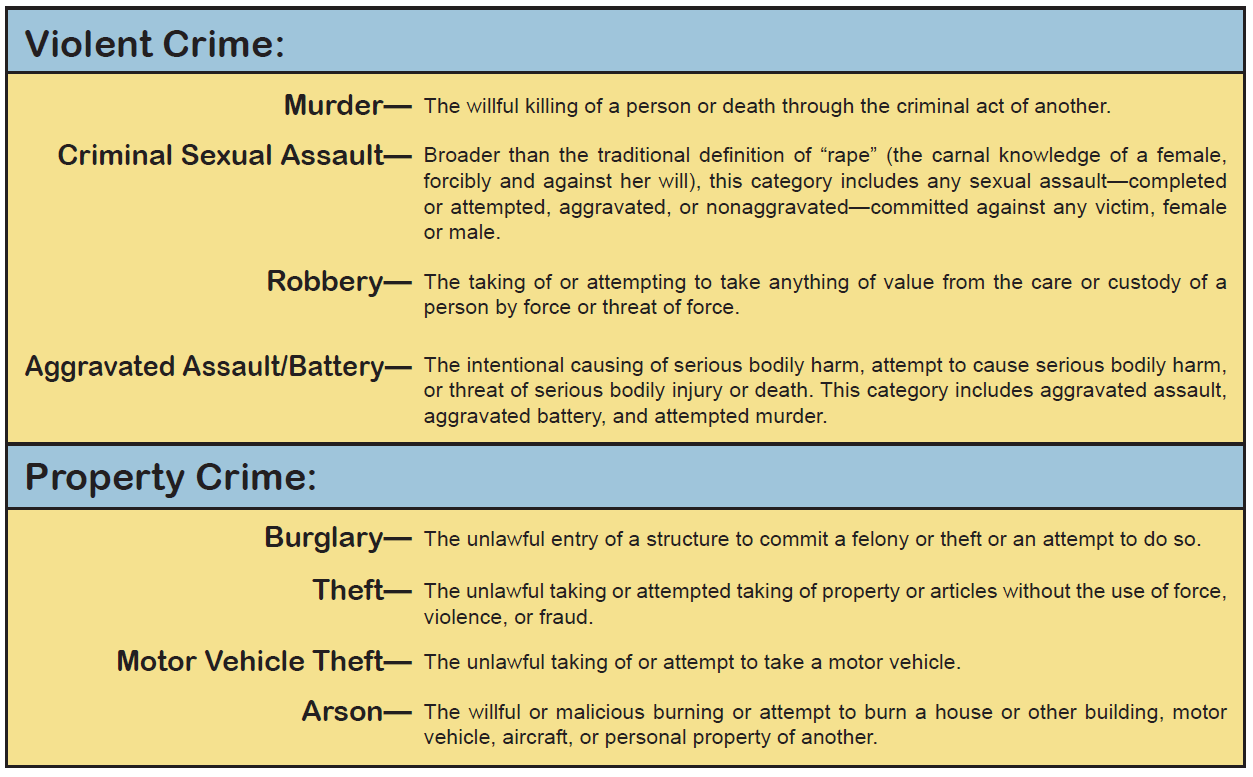


# Chicago Crimes Dataset

The CSV file for crimes dataset for  the city of Chicago is obtained from the data portal for the city of Chicago. Here is the link for the city of Chicago data portal __[City of Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2)__ 

### Dataset CSV files

Three datasets are used in this assignment:
1. The Chicago police stations in every district
2. The Boundaries.geojson data for district boundries
3. The Crimes dataset 


Complete description of the dataset can be found on Chicago city data portal.

Since we are using PostGIS in our work, please read and bookmark __[Chapter 4. Using PostGIS: Data Management and Queries](https://postgis.net/docs/manual-1.4/ch04.html)__ 


In [37]:
import folium
from folium import plugins
from folium.plugins import MarkerCluster
import psycopg2
import csv
import pandas as pd
import json
from area import area

from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT 


# IMPORTANT NOTES:
- In this  assignment you will be connecting to DSCC PostgreSQL server that has the database and tables already created on the server. 
- You need to use your NetID (your netid is case-sensitive) and password for login and passward to connect PostgreSQL server hosted on DSCC
- For the psycopg2.connect statements listed below, you must provide your NetID and password in order to connect to PostgreSQL server hosted on DSCC
- For the **dbname** below use **chicago_crimes_ut** as your database while debugging/testing your code and use **chicago_crimes** as your database for your final submission
- For the purpose of uploading this notebook to Github, I will use the reduced testing dataset

In [38]:
# Use this data set for your final submission of your Assignment 3
# Uncomment the following line after you unit test your code and ready to run and submit your assignment on this dataset 

# db_connection = psycopg2.connect(host='129.105.248.26',dbname="chicago_crimes", user="xxx" , password="xxx!")

# Use the following dataset for unit testing purposes only. It takes roughly 5 minutes to omplete.
# Comment the following line when you are done with your unit testing and ready to run your assignment on the complete dataset and submit your Assignment 

db_connection = psycopg2.connect(host='129.105.248.26',dbname="chicago_crimes_ut", user="xxx" , password="xxx!")


cursor = db_connection.cursor()

### Chicago Crimes Dataset

The chicago crimes database on the DSCC/PostgreSQL server was created using data from the Crimes_2001_to_present.csv file that is available on Chicago data portal.

While working on this dataset, It is prudent to make a note of the following:
1. Geospatial  queries are very demanding for system resouces like CPU, GPU, Memory, and DISK
1. We are interested in the data set of the past 2 years, and when you execute Geospatial type queries, please be advised that these queries slow down your machine. 
2. There are two dataset that you will use in this assignment
    - **chicago_crimes_ut**  : Use this  mini dataset that has data for rougly a month for coding/debugging and unit testing
    - **chicago_crimes** : Use this dataset that has data for 2 years for your final submission


### Algorithm Performance

- **Sort algorithms** used by the database engines vary in performance between O($N log N$) and O($ N^{2} $) where $N$ is the size of the number

- **Search algorithms** used by the database engines vary in performance between O($log N$) and O($ N $) where $N$ is the size of the number




## Practice Query:
- Calculate the total number of **gun related violent crimes** in every district and plot that in a table on Choropleth map


Lets first create a dataframe of gun crimes per district first to get an idea about the number of gun crimes per district


In [40]:

gun='%GUN%'
cursor.execute("SELECT district, count(district) from crimes where DESCRIPTION::text LIKE %s GROUP BY district",[gun])
districts_gun_violent_crimes = cursor.fetchall()
districts_gun_violent_crimes_df = pd.DataFrame(districts_gun_violent_crimes, columns=['dist_num','gun_crimes'])
districts_gun_violent_crimes_df['dist_num'] = districts_gun_violent_crimes_df['dist_num'].astype(str)
districts_gun_violent_crimes_df.head()

dist_num  gun_crimes
0       24           9
1        8          49
2       11          69
3       19          11
4       25          43

### Requirement #1: 
- Calculate the gun crimes density in every district

In [41]:
district=[]
tarea=[]

with open('Boundaries.geojson') as f:
    data = json.load(f)
    a = data['features']
    for i in range(len(a)):
        obj=a[i]['geometry']
        n= a[i]['properties']
        district.append(n['dist_num'])
        tarea.append(area(obj)/10000)

af=pd.DataFrame({'dist_num': district,'district_area_inHectares':tarea})
af['dist_num'] = af['dist_num'].astype(str)
final_gun_data= pd.merge(af, districts_gun_violent_crimes_df, on='dist_num', how='inner')
final_gun_data['gun_crime_density'] = round(final_gun_data['gun_crimes']/(final_gun_data['district_area_inHectares']/100))
final_gun_data.head()

dist_num  district_area_inHectares  gun_crimes  gun_crime_density
0       17               2492.727155           7                0.0
1       20               1132.170216           5                0.0
2       19               2225.035732          11                0.0
3       25               2827.989237          43                2.0
4       14               1555.869965          12                1.0

### Requirement #2: 
- Locate the **farthest** UNLAWFUL POSS OF HANDGUN crime from the police station in every district. The popup on Choropleth map shall display the district number and the block

In [42]:
farthest_unlawful_block_gun_crime_map = folium.Map(location =(41.8781, -87.6298),zoom_start=11)
folium.Choropleth(geo_data="Boundaries.geojson", 
              fill_color='YlOrRd', 
              fill_opacity=0.5, 
              line_opacity=1,
              data = districts_gun_violent_crimes_df,
              key_on='feature.properties.dist_num',
              columns = ['dist_num', 'gun_crimes'],
              legend_name="GUN CRIME"
              ).add_to(farthest_unlawful_block_gun_crime_map)


In [43]:
cursor.execute("""SELECT ST_X(ST_AsText(Where_IS)), ST_Y(ST_AsText(Where_IS)), district from police_stations where district!='Headquarters'""")
police_stations = cursor.fetchall()

handgun='%UNLAWFUL%'

for police_station in police_stations:
    
    cursor.execute("""
                        WITH crime_distance_from_police_station AS (
                                        SELECT  A.where_is as crime_where_is, 
                                                B.where_is as police_where_is,
                                                A.district as crime_district,
                                                A.block as crime_block,
                                                ST_Distance(A.where_is,B.where_is) as distance 
                                        FROM crimes as A, police_stations as B 
                                        WHERE A.district=%s and DESCRIPTION::text LIKE %s and B.district= %s 
                        )
    
                        SELECT DISTINCT on (crime_distance_from_police_station.crime_block) 
                                        crime_distance_from_police_station.crime_district,
                                        crime_distance_from_police_station.crime_block, 
                                        crime_distance_from_police_station.crime_where_is,
                                        crime_distance_from_police_station.distance 
                        FROM crime_distance_from_police_station 
                        WHERE distance = (SELECT max(distance) 
                                        FROM crime_distance_from_police_station )""",[police_station[2],handgun,police_station[2]])
    
    farthest_unlawful_block_gun_crime = cursor.fetchall()

    cursor.execute("SELECT ST_X(ST_AsText(%s)), ST_Y(ST_AsText(%s))",(farthest_unlawful_block_gun_crime[0][2],farthest_unlawful_block_gun_crime[0][2]))
    farthest_unlawful_block_gun_crime_location = cursor.fetchall()
    folium.Marker(location=(police_station[0],police_station[1]),popup=folium.Popup(html="Police Station <br> District No.:%s <br> Farthest Unlawful_Gun_Crime Block:%s"%(farthest_unlawful_block_gun_crime[0][0],farthest_unlawful_block_gun_crime[0][1]))).add_to(farthest_unlawful_block_gun_crime_map)
    folium.CircleMarker(farthest_unlawful_block_gun_crime_location[0],radius=5,color='#ff3187',popup=folium.Popup(html="District No.:%s <br> Block:%s"%(farthest_unlawful_block_gun_crime[0][0],farthest_unlawful_block_gun_crime[0][1]))).add_to(farthest_unlawful_block_gun_crime_map) 




In [44]:
farthest_unlawful_block_gun_crime_map

### Requirement #3: 

- Create **Marker Clusters** on Choropleth map for those **gun related violent crimes** that have Location Desciption as RESIDENCE in ** (green icon)** and those that have Location Desciption as STREET in **(red icon)**

In [45]:
#first map
gun_crime_location_map = folium.Map(location =(41.8781, -87.6298),zoom_start=11)
folium.Choropleth(geo_data="Boundaries.geojson", 
              fill_color='YlOrRd', 
              fill_opacity=0.5, 
              line_opacity=1,
              data = districts_gun_violent_crimes_df,
              key_on='feature.properties.dist_num',
              columns = ['dist_num', 'gun_crimes'],
              legend_name="GUN CRIME"
              ).add_to(gun_crime_location_map)

In [46]:
cursor.execute("""SELECT ST_X(ST_AsText(Where_IS)), ST_Y(ST_AsText(Where_IS)), district from police_stations where district!='Headquarters'""")
gun='%GUN%'

police_stations = cursor.fetchall()

marker_cluster = MarkerCluster().add_to(gun_crime_location_map)

for police_station in police_stations:
    police_station_location = (police_station[0],police_station[1])
    cursor.execute("""SELECT DISTINCT ON(caseno) caseno, block,DESCRIPTION, count(arrest), arrest,latitude, longitude, location_description from crimes where district=%s and DESCRIPTION::text LIKE %s GROUP BY caseno,block, DESCRIPTION,arrest, latitude, longitude, location_description""",[police_station[2],gun])
    crimes_per_district2 = cursor.fetchall()
    for crime in crimes_per_district2:
        if crime[7]=='RESIDENCE':
            folium.Marker(location=(crime[5],crime[6]),popup=folium.Popup(html="District No: %s <br> Location: %s <br> Description: %s<br> Block: %s" %(police_station[2],crime[7],crime[2],crime[1])),icon=folium.Icon(color='green', icon='ok-sign'),).add_to(marker_cluster)
        if crime[7]=='STREET':
            folium.Marker(location=(crime[5],crime[6]),popup=folium.Popup(html="District No: %s <br> Location: %s <br> Description: %s<br> Block: %s" %(police_station[2],crime[7],crime[2],crime[1])),icon=folium.Icon(color='red', icon='remove-sign'),).add_to(marker_cluster)            
        else:
            folium.Marker(location=(crime[5],crime[6]),popup=folium.Popup(html="District No: %s <br> Location: %s <br> Description: %s<br> Block: %s" %(police_station[2],crime[7],crime[2],crime[1])),icon=folium.Icon(color='blue', icon='info-sign'),).add_to(marker_cluster)


In [47]:
#map
gun_crime_location_map

In [ ]:
#alternatively we could have used the below to not use a blue marker
cursor.execute("""SELECT ST_X(ST_AsText(Where_IS)), ST_Y(ST_AsText(Where_IS)), district from police_stations where district!='Headquarters'""")
gun='%GUN%'
police_stations = cursor.fetchall()
marker_cluster = MarkerCluster().add_to(gun_crime_arrests_map)
for police_station in police_stations:
    police_station_location = (police_station[0],police_station[1])
    cursor.execute("""SELECT DISTINCT ON(caseno) caseno, block,DESCRIPTION, count(arrest), arrest,latitude, longitude,location_description from crimes where (district=%s) and  (location_description IN ('STREET', 'RESIDENCE'))  and (DESCRIPTION::text LIKE %s) GROUP BY caseno,block, DESCRIPTION,arrest, latitude, longitude, location_description""",[police_station[2],gun])
    crimes_per_district = cursor.fetchall()
    for crime in crimes_per_district:
        if crime[7] == 'RESIDENCE' :
            folium.Marker(location=(crime[5],crime[6]),popup=folium.Popup(html="District No: %s <br> Description: %s <br> Block: %s" %(police_station[2],crime[2],crime[1])),icon=folium.Icon(color='green', icon='ok-sign'),).add_to(marker_cluster)
        else:
            folium.Marker(location=(crime[5],crime[6]),popup=folium.Popup(html="District No: %s <br> Description: %s<br> Block: %s" %(police_station[2],crime[2],crime[1])),icon=folium.Icon(color='red', icon='remove-sign'),).add_to(marker_cluster)

### Requirement #4: 
- Locate the **Block** that has the **higest number of gun crimes**.

In [48]:
gun='%GUN%'
cursor.execute("SELECT district, block, count(block) from crimes where DESCRIPTION::text LIKE %s GROUP BY block, district",[gun])
gun_crimes = cursor.fetchall()
gun_crimes = pd.DataFrame(gun_crimes, columns=['dist_num','block','gun_crimes'])
gun_crimes['dist_num'] = gun_crimes['dist_num'].astype(str)
gun_crimes.tail()
# gun_crimes.shape
max_gun_crimes = gun_crimes['gun_crimes'].max()
print(max_gun_crimes)
gun_crimes[gun_crimes['gun_crimes']==39]

3


Empty DataFrame
Columns: [dist_num, block, gun_crimes]
Index: []

I had to reduce the file size to upload it to Github, so I used a reduced dataset. With the reduced dataset, nothing is shown above. If I were to use the entire dataset, then the block below would have had the highest amount of gun crimes.

dist_num: 3883
<br>
block: 3 064XX S DR MARTIN LUTHER KING JR DR
<br>
gun_crimes: 39

In [49]:
gun='%GUN%'

cursor.execute("SELECT district, block, count(*) AS number_of_crimes from crimes where DESCRIPTION::text LIKE %s GROUP BY district, block  ORDER BY district ASC, count(*) DESC", [gun])
rows=cursor.fetchall()


crimes_per_block = pd.DataFrame(rows, columns=['dist_num', 'block','number_of_crimes'])
crimes_per_block['block'] = crimes_per_block['block'].astype(str)

crimes_per_block.head()

crimes_per_district_blocks = crimes_per_block.groupby('dist_num')


df_highest_crime_number_per_district_block  = pd.DataFrame()

    
    
for district, group in crimes_per_district_blocks:
    block_with_highest_crime_number = group.sort_values(by='number_of_crimes', ascending=False)[:1]
    df_highest_crime_number_per_district_block = df_highest_crime_number_per_district_block.append(block_with_highest_crime_number)



df_highest_crime_number_per_district_block.head()

dist_num                  block  number_of_crimes
0           1    029XX S DEARBORN ST                 1
6           2  044XX S GREENWOOD AVE                 2
39          3     071XX S WABASH AVE                 3
91          4        013XX E 87TH ST                 2
138         5      130XX S ELLIS AVE                 2

The block with the highest number of gun crimes from each district